<a href="https://colab.research.google.com/github/maronga/Maize-Crop-Disease-Detection-Using-Machine-Learning-and-Computer-Vision/blob/main/Copy_of_Copy_of_CNN_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Maize Crop Disease Prediction

## 1.Defining the Question

### a) Specifying the Data Analytic Question

### b) Defining the Metric for Success

### c) Understanding the context 

### d) Recording the Experimental Design

### e) Data Relevance

In [2]:
# Importing the necessary libraries
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [18]:
# Checking the tensorflow version
print(tf.__version__)

2.8.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import imghdr

def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                  bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir =r'/content/drive/Shareddrives/Group 1 /Maize Disease Dataset'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  Healthy Maize
processing class directory  Maize Gray leaf spot
processing class directory  Maize Common rust_
processing class directory  Maize streak disease
processing class directory  Maize northern leaf blight
processing class directory  Maize Head smut
 no improper image files were found


## Loading the dataset

In [15]:
#Defining the parameters for the loader
batch_size = 10
img_height = 256
img_width = 256

In [16]:
# Splitting the dataset when loading using the validation split
# 80% of the dataset will be used for training  and the rest for validation
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/Shareddrives/Group 1 /Maize Disease Dataset',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 582 files belonging to 6 classes.
Using 466 files for training.


In [17]:
# 20% of the result will be used for validation
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/Shareddrives/Group 1 /Maize Disease Dataset',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 582 files belonging to 6 classes.
Using 116 files for validation.


In [7]:
# Checking the class names
class_names = train_ds.class_names
print(class_names)

['Healthy Maize', 'Maize Common rust_', 'Maize Gray leaf spot', 'Maize Head smut', 'Maize northern leaf blight', 'Maize streak disease']


## Visualizing the data

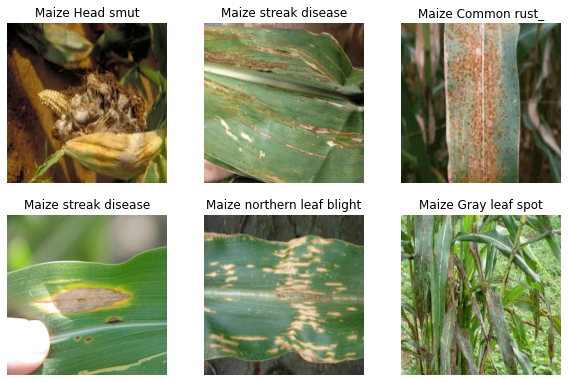

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 256, 256, 3)
(10,)


Observation: The image batch is a batch of 10 images of shape 250x250x3, 3 being the color channels RGB. The labels batch is a batch of 10 images 


## Standardizing the data

In [ ]:
# The RGB channel values are in the [0,255] range which are large and should standardize the values
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9997456


## Configuring the dataset for perfomance

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Training the Model

In [27]:
num_classes = 6

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [28]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [30]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=12
)

Epoch 1/12
47/47 [==============================] - 91s 2s/step - loss: 1.8807 - accuracy: 0.2017 - val_loss: 1.7573 - val_accuracy: 0.2759
Epoch 2/12
47/47 [==============================] - 2s 38ms/step - loss: 1.7265 - accuracy: 0.2511 - val_loss: 1.6913 - val_accuracy: 0.3707
Epoch 3/12
47/47 [==============================] - 2s 36ms/step - loss: 1.6570 - accuracy: 0.3262 - val_loss: 1.6282 - val_accuracy: 0.3879
Epoch 4/12
47/47 [==============================] - 2s 36ms/step - loss: 1.5827 - accuracy: 0.3541 - val_loss: 1.6310 - val_accuracy: 0.3448
Epoch 5/12
47/47 [==============================] - 2s 36ms/step - loss: 1.4313 - accuracy: 0.4764 - val_loss: 1.6637 - val_accuracy: 0.3621
Epoch 6/12
47/47 [==============================] - 2s 36ms/step - loss: 1.2310 - accuracy: 0.5365 - val_loss: 1.3982 - val_accuracy: 0.4655
Epoch 7/12
47/47 [==============================] - 2s 36ms/step - loss: 0.8592 - accuracy: 0.6888 - val_loss: 1.5318 - val_accuracy: 0.4914
Epoch 8/12
47/

In [31]:
# Viewing all layers of the networki
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 32)       